# Image Classification Project: Golf, Tennis, and Table Tennis

In this project, we build a classification model using a Residual Neural Network (ResNet). The model aims to discriminate among pictures about golf, tennis, and table tennis. The dataset used in this project contains 1,500 images collected via Google Images. The model achieves an accuracy of 98.2%. Using transfer learing, we are able to train the network within a very short amount of time, i.e., a few minutes. The project can be extended to a web-based application for online image classification.  

We first start by setting the libraries used in this notebook to be automatically reloaded if their source codes are changed during runtime. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We utilize the `fastai` library for fast model building and testing.

In [2]:
from fastai.vision import *

from fastai.metrics import error_rate

bs = 64

# Creating Folders and Downloading Images 

In this section, we create three separate folders for storing the images of each category. The links to those images are obtained from Google Images. Next, we download the images to their corresponding folders.

In [ ]:
folder = 'tennis'
file = 'urls_tennis.csv'

path = Path('/home/ubuntu/Prj1')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(path/file, dest, max_pics=500)

In [ ]:
folder = 'golf'
file = 'urls_golf.csv'

path = Path('/home/ubuntu/Prj1')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(path/file, dest, max_pics=500)

In [ ]:
folder = 'table_tennis'
file = 'urls_table_tennis.csv'

path = Path('/home/ubuntu/Prj1')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
download_images(path/file, dest, max_pics=500)

We then verify if the downloaded images can actually be opened. If there is an error, we simply delete the images.

In [ ]:
path = Path('/home/ubuntu/Prj1')
classes = ['tennis','golf','table_tennis']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# Exploring Data

In this section, we look at a few samples of the data and prepare the data for training and testing using `ImageDataBunch` from the `fastai` library.

In [3]:
path = Path('/home/ubuntu/Prj1')
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs=bs, num_workers=4).normalize(imagenet_stats)

We ensure that the data has three classes.

In [4]:
data.classes

['golf', 'table_tennis', 'tennis']

Let's look at some samples of the data.

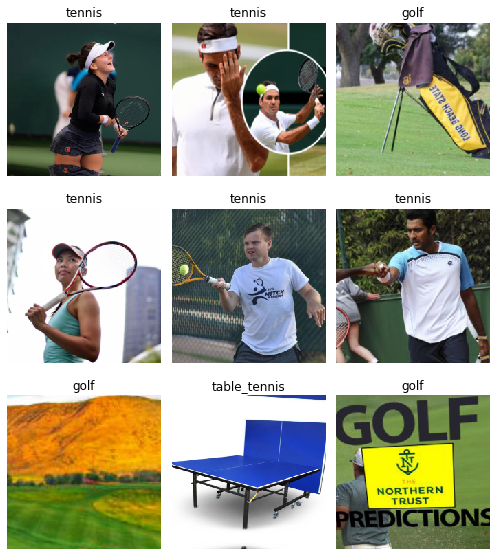

In [5]:
data.show_batch(rows=3, figsize=(7,8))

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['golf', 'table_tennis', 'tennis'], 3, 1092, 273)

We see that we have three classes in our dataset. 1,092 data points are used for tranining, and 273 photos are used for validating purpose.

# Training Resnet34

In this section, we train a ResNet with 34 layers. We use a pre-trained model of ResNet that has been trained with the ImageNet dataset. We use the error rate as the performance metric.

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [8]:
from fastai.callbacks import *

We first train the model using a few number of epochs. The best model is saved as `stage-1`.

epoch,train_loss,valid_loss,error_rate,time
0,0.793911,0.137679,0.036630,00:26
1,0.428293,0.077482,0.021978,00:11
2,0.288964,0.070167,0.018315,00:12
3,0.221184,0.066848,0.021978,00:12


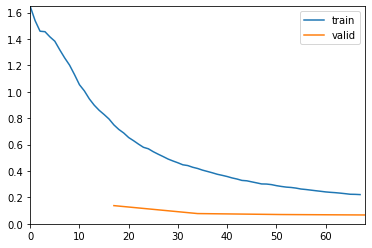

Better model found at epoch 0 with error_rate value: 0.03663003817200661.
Better model found at epoch 1 with error_rate value: 0.021978022530674934.
Better model found at epoch 2 with error_rate value: 0.018315019086003304.


In [9]:
learn.fit_one_cycle(4, callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='error_rate', mode='min', name='stage-1')])

We see that training tooks only about a minute to complete 4 epochs. However, the error rate is already low, i.e., about 1.8%. At the end of the 4th epochs, the training loss is still higher than the validation loss, suggesting that we can further fine-tune the parameter to achieve better performance.

# Initial Evaluation

In this section, we see the initial evaluation of the model after training just a few epochs. We will fist take a look at the top losses plot and the confusion matrix, which demonstrate the mistakes that the model made.

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

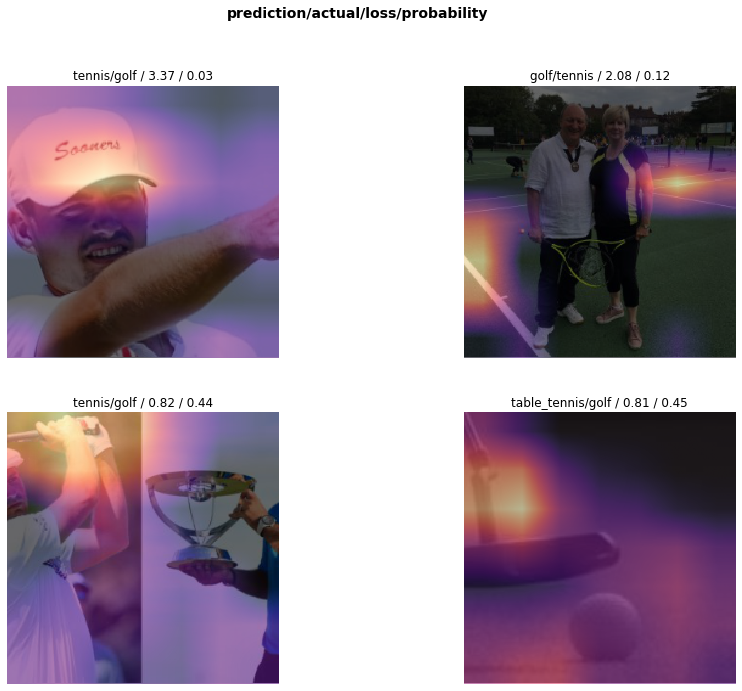

In [17]:
interp.plot_top_losses(4, figsize=(15,11))

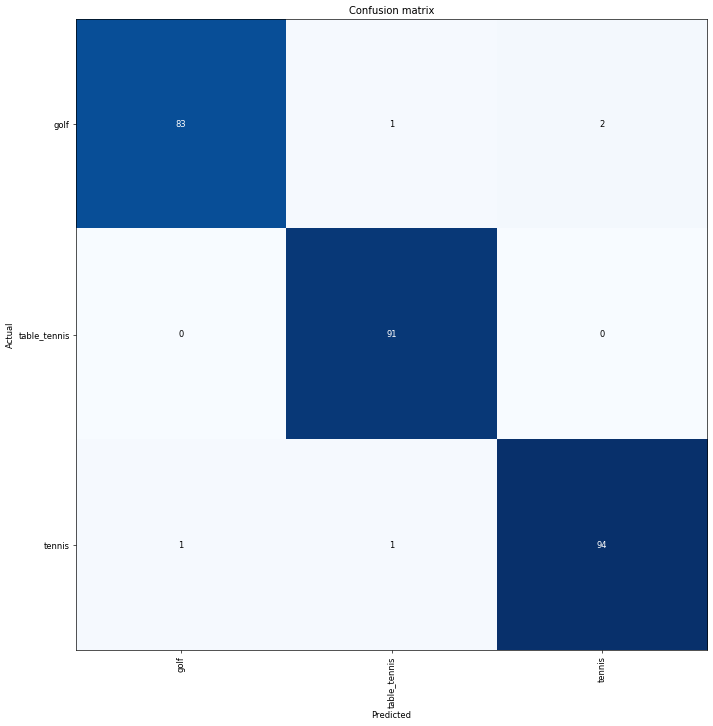

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Fine-tunning the model

In this section, we fine-tune the model by unfreezing the whole network and continue training. The best learning rate is obtained via the learning rate versus loss plot.

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


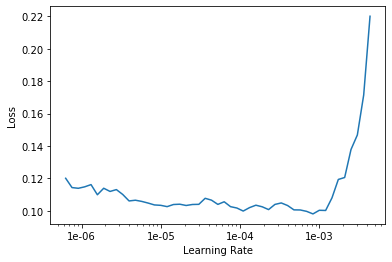

In [21]:
learn.recorder.plot()

Based on the plot, we decide a range for the learning rate as follows.

epoch,train_loss,valid_loss,error_rate,time
0,0.122590,0.071506,0.018315,00:14
1,0.106448,0.067929,0.018315,00:14
2,0.087988,0.060929,0.021978,00:14
3,0.073799,0.060534,0.018315,00:14


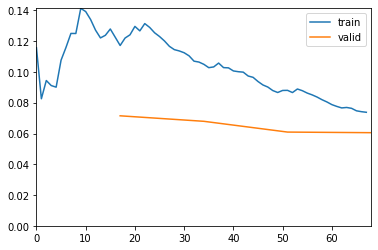

Better model found at epoch 0 with error_rate value: 0.018315019086003304.


In [22]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4), callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='error_rate', mode='min', name='stage-2')])

We see that the training loss is approaching the validation loss. We further fine-tune the model by using a even smaller learning rate.

epoch,train_loss,valid_loss,error_rate,time
0,0.104255,0.076680,0.021978,00:14
1,0.093677,0.070163,0.021978,00:14
2,0.090698,0.069999,0.018315,00:14
3,0.084153,0.068659,0.025641,00:14
4,0.084958,0.066876,0.021978,00:14
5,0.078689,0.067326,0.021978,00:14


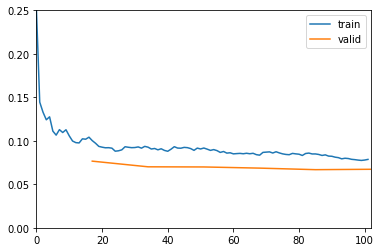

Better model found at epoch 0 with error_rate value: 0.021978022530674934.
Better model found at epoch 2 with error_rate value: 0.018315019086003304.


In [23]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-5), callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='error_rate', mode='min', name='stage-3')])

# Second Evaluation

In this section, we re-evaluate the model after parameter fine-tuning. 

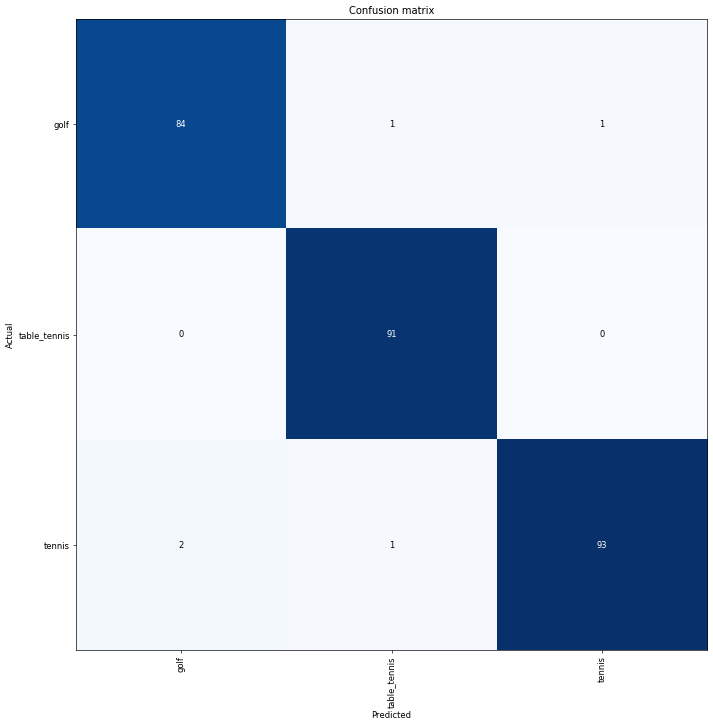

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Cleaning Images & Retraining Model

In this section, we investigate if we can further improve the performance by looking at the dataset and remove the 'bad' data points using the `ImageCleaner` widget.

In [25]:
from fastai.widgets import *

In [26]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [37]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-3');

In [38]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [39]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

After cleaning the dataset using the widget, a csv file containing the indices of the cleaned dataset is created. We will train the model again based on this cleaned dataset.

In [40]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
                               ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

epoch,train_loss,valid_loss,error_rate,time
0,0.747597,0.151367,0.047794,00:12
1,0.415033,0.137622,0.047794,00:12
2,0.276919,0.114054,0.044118,00:11
3,0.206802,0.108225,0.040441,00:11


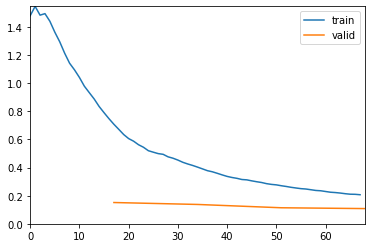

Better model found at epoch 0 with error_rate value: 0.04779411852359772.
Better model found at epoch 2 with error_rate value: 0.04411764815449715.
Better model found at epoch 3 with error_rate value: 0.040441177785396576.


In [41]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(4, callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='error_rate', mode='min', name='stage-4')])

In [42]:
learn.unfreeze()

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


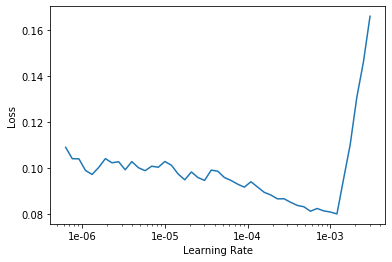

In [44]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.116650,0.133726,0.044118,00:14
1,0.102181,0.223960,0.047794,00:14
2,0.081896,0.159471,0.051471,00:14
3,0.076778,0.075753,0.025735,00:14


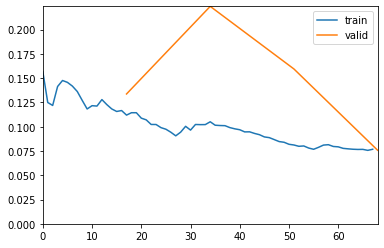

Better model found at epoch 0 with error_rate value: 0.04411764815449715.
Better model found at epoch 3 with error_rate value: 0.025735294446349144.


In [45]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,1e-3), callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='error_rate', mode='min', name='stage-5')])

epoch,train_loss,valid_loss,error_rate,time
0,0.052178,0.072432,0.022059,00:14
1,0.049996,0.074477,0.025735,00:14
2,0.045385,0.077655,0.025735,00:14
3,0.038351,0.079212,0.022059,00:14
4,0.035362,0.074495,0.018382,00:14
5,0.032722,0.076118,0.022059,00:14


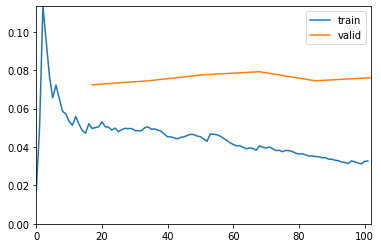

Better model found at epoch 0 with error_rate value: 0.022058824077248573.
Better model found at epoch 4 with error_rate value: 0.018382353708148003.


In [46]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-5), callbacks=[ShowGraph(learn), SaveModelCallback(learn, monitor='error_rate', mode='min', name='stage-6')])

We see that we obtain a similar performance, the ResNet is robust to noise in the dataset.

# Conclusion

In this project, we created a ResNet for discriminating golf images, tennis images, and table tennis images. The best accuracy achieved is 98.15%. The model can be applied to a bigger dataset with more classes, as well as be embedded in web applications.